# **Mapping and Perception for an autonomous robot (0510-7951)**
---
* **Exercise 4-section 2: Detection, Segmentation and Multi Object Tracking**

In this exercise we provide you with a baseline multi-object tracker on the [MOT16](https://motchallenge.net/data/MOT16/) dataset. Your task is to analize detection and tracking results based on different techniques from the lectures. 
We will use [MOT17Det Dataset](https://arxiv.org/pdf/1603.00831.pdf).See the [webpage](https://motchallenge.net/) for video sequences with ground truth annotation

* **Goals**

1. Experience with [**MOT challenge Dataset**](https://motchallenge.net/) and pytorch!

2. Object Detection with [**Faster R-CNN** ]( https://www.learnopencv.com/faster-r-cnn-object-detection-with-pytorch/)

3. Instance segemenation based on [**Mask-RCNN**](https://arxiv.org/abs/1703.06870)

4. Object Detection with YOLO5 [**YOLO5V5 in pytorch**]( https://pytorch.org/hub/ultralytics_yolov5/)

5. Object Detection (Faster R-CNN) + Multiple Object(ID) Tracking with Simple Online and Realtime Tracking [**SORT**](https://arxiv.org/abs/1602.00763)

6. Multi Target Tracking: Run given baseline of Multiple Object(ID) Tracking and compare to current state-of-the-art multi-object tracker [**Tracktor++**](https://arxiv.org/abs/1903.05625)


* **Please copy to the report:**
1. Outputs- Images, tables, scores,etc
2. Code ("TODO" section)
3. Performace, analysis and your explanations. 
4. Attach the completed notebook to the report package. 
* ## Setup

 Download and extract project data to your Google Drive

1.   Install Google Drive on your desktop.
2.   Save this notebook to your Google Drive by clicking `Save a copy in Drive` from the `File` menu.
3.   Download attched **exercise.rar** file to your desktop and extract it into the `Colab Notebooks` folder in your Google Drive.
4. Go to [**MOT 16 dataset**](https://motchallenge.net/data/MOT16/) ,at the bottom of the page go to download--> "Get all data"
then Copy the MOT 16 dataset to "\exercise\data\MOT16"
5.   Wait until Google Drive finished the synchronisation. (This might take a while.)


* **TODO**

1. Student name: Osher Azulay

2. ID: 203099247

#### Connect the notebook to your Google Drive

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
root_dir = "gdrive/My Drive/Colab Notebooks/perception"

The `root_dir` path points to the directory and the content in your Google Drive.

In [3]:
!ls "gdrive/My Drive/Colab Notebooks/perception"
!ls "gdrive/My Drive/Colab Notebooks/perception/src/tracker"

data  models  output  src
data_obj_detect.py  __init__.py		__pycache__  utils.py
data_track.py	    object_detector.py	tracker.py


#### Install and import Python libraries

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
sys.path.append(os.path.join(root_dir, 'src'))

!pip install tqdm lap
!pip install https://github.com/timmeinhardt/py-motmetrics/archive/fix_pandas_deprecating_warnings.zip

     |████████████████████████████████| 1.5MB 34.7MB/s 
  Created wheel for lap: filename=lap-0.4.0-cp37-cp37m-linux_x86_64.whl size=1590139 sha256=69d76191f5b6e8b21e2070b17c256671c5b4512910e53da7bc59b269f6b94500
  Stored in directory: /root/.cache/pip/wheels/da/3e/af/eddcd6ffaa27df8d0ddac573758f8953c4e57c64c4c8c8b7d0
Successfully built lap
     - 215kB 10.6MB/s
  Created wheel for motmetrics: filename=motmetrics-1.1.3-cp37-none-any.whl size=134200 sha256=8684e3c4dbcbc59b2242e3d4bed566175b988cd4bcc30afd214f1dacce30ad0a
  Stored in directory: /tmp/pip-ephem-wheel-cache-g7kek4cj/wheels/c9/e9/0a/79599df270874df0ab21a57a729e8a956aed3c744da3397efc
Successfully built motmetrics


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm.autonotebook import tqdm

import torch
from torch.utils.data import DataLoader

from tracker.data_track import MOT16Sequences
from tracker.data_obj_detect import MOT16ObjDetect
from tracker.object_detector import FRCNN_FPN ##FasterRCNN
from tracker.tracker import Tracker
from tracker.utils import (plot_sequence, evaluate_mot_accums, get_mot_accum,
                           evaluate_obj_detect, obj_detect_transforms)

import motmetrics as mm
mm.lap.default_solver = 'lap'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


# MOT16 dataset

The MOT16 challenge provides 7 train and 7 test video sequences with multiple objects (pedestrians) per frame. It includes many challening scenarios with camera movement, high crowdedness and object occlusions. See the [webpage](https://motchallenge.net/data/MOT16/) for video sequences with ground truth annotation.

The `MOT17Sequences` dataset class provides the possibilty to load single sequences, e.g., `seq_name = 'mot16_02'`, or the entire train/test set, e.g., `seq_name = 'mot16_train'`.

In [6]:
!ls "gdrive/My Drive/Colab Notebooks/perception/data/MOT16/train"
!ls "gdrive/My Drive/Colab Notebooks/perception/data/MOT16/test"

MOT16-02  MOT16-04  MOT16-05  MOT16-09	MOT16-10  MOT16-11  MOT16-13
MOT16-01  MOT16-03  MOT16-06  MOT16-07	MOT16-08  MOT16-12  MOT16-14


In order to compare the tracking performance of different trackers without the effect of the object detector, the MOTChallenge provides a precomputed set of public object detections. Trackers are then evaluated on their capabilities to form tracks with the provided set. However, we want to allow you to improve on the object detections as well. Therefore, we participate in the MOT16 challenge with private detections.

## Instance segmentations

We provide the instance segmentations for the sequences `02`, `05`, `09` and `11`. These can be used for example to train a method which improves the bounding box position in occluded situations. See the original MOTS [webpage](https://www.vision.rwth-aachen.de/page/mots) for more info.

In [7]:

from tracker.data_track import MOT16Sequences
from tracker.data_obj_detect import MOT16ObjDetect
from tracker.object_detector import FRCNN_FPN #FasterRCNN
from tracker.tracker import Tracker




In [8]:
seq_name = 'MOT16-09' #TODO: # selcect the Sequences number (#) which most close to the your final ID number
data_dir = os.path.join(root_dir, 'data/MOT16')
sequences = MOT16Sequences(seq_name, data_dir, load_seg=True)

1.1 TODO: Select an image for the sequences according to your final number in your ID X10 . copy results to the report

1.2 TODO: Display the image + Bounding boxes(GT)

1.3 TODO: Display the mask image of segmentation (GT)



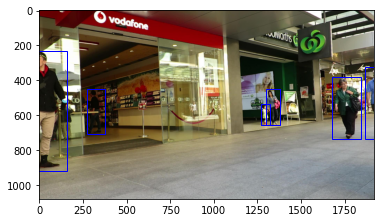

In [ ]:
seq = sequences[0]
#1.1 TODO: Select an image for the sequences according to your final number in your ID X10 . copy results to the report
frame = seq[7] # selcect image according to the final number in your ID X10
img=frame['img']
gt=frame['gt']
# 1.2 TODO: Display the image + Bounding boxes(GT)
# hint- gt_id, Bounding boxes in gt.items()
dict_gt_key = list(gt.keys()) # Get key of BB associated to chosen image
fig,ax = plt.subplots(1)
# Display the image
ax.imshow(img.permute(1, 2, 0))
import matplotlib.patches as mpatches
# Create a Rectangle patch
for i in range(len(gt)):
  cur_gt = gt[dict_gt_key[i]]
  x = cur_gt[0]
  y = cur_gt[1]
  w = cur_gt[2]-x
  h = cur_gt[3]-y
  color = list(np.random.choice(range(256), size=3))
  rect = mpatches.Rectangle((x,y),w,h,linewidth=1,edgecolor='b',facecolor='none')
  ax.add_patch(rect)


dict_keys(['img', 'img_path', 'gt', 'vis', 'seg_img'])


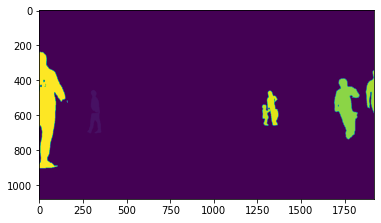

In [ ]:
print(frame.keys())
seg_img = frame['seg_img']
plt.imshow(seg_img)

# 1.3 TODO: Display the mask image of segmentation (GT)

2.1 TODO: Implement instance segemenation based on maskRCNN (in PyTorch)

2.2 Run and the same image (copy results to the report) and compare results to given instance segmenation GT 

Bonus- use IoU/Dice score metrics(+3)

In [ ]:
import os
from os.path import exists, join, basename, splitext
from torchvision import transforms as T

import random
import PIL
import torchvision
import cv2
import numpy as np
import torch
torch.set_grad_enabled(False)
  
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

#2.1 TODO: Implement instance segemenation based on maskRCNN (in PyTorch)
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model = model.eval().cuda()

In [ ]:
def get_prediction(img, threshold=0.5, url=False):

  # transform = T.Compose([T.ToTensor()]) # Turn the image into a torch.tensor
  # img = transform(img) #torchvision.transforms.functional.to_tensor(img).cuda()
  img = img.cuda() # Only if GPU, otherwise comment this line
  pred = model([img]) 
  # pred = pred.cpu() # We will just send predictions back to CPU
  # Now we need to extract the bounding boxes and masks
  pred_score = list(pred[0]['scores'].detach().cpu().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
  masks = (pred[0]['masks'] > 0.5).squeeze().detach().cpu().numpy()
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  return masks, pred_boxes

In [ ]:

import torch
import random

def random_color_masks(image):
  # I will copy a list of colors here
  colors = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180], [250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image==1], g[image==1], b[image==1] = colors[random.randrange(0, 10)]
  colored_mask = np.stack([r,g,b], axis=2)
  return colored_mask

# 2.2 Run and the same image (copy results to the report) and compare results to given instance segmenation GT
#hint use: torchvision.transforms.functional.to_tensor(pil_image_single).cuda()


In [ ]:
def instance_segmentation(img, threshold=0.5, rect_th=3,
                          text_size=3, text_th=3, url=False):
  masks, boxes = get_prediction(img, threshold=threshold, url=url)
  img = img.permute(1, 2, 0).cpu().detach().numpy()
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # For working with RGB images instead of BGR

  for i in range(len(masks)):
    rgb_mask = random_color_masks(masks[i])
    img = np.asarray(img, np.float64)
    rgb_mask = np.asarray(rgb_mask, np.float64)

    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
    cv2.rectangle(img, boxes[i][0], boxes[i][1], color=(0, 255, 0), thickness=rect_th)
    # cv2.putText(img, pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)
  return img, masks[i]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


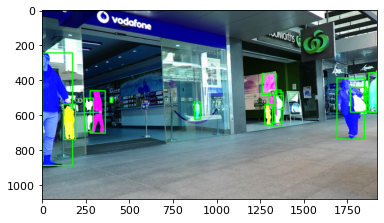

In [ ]:
img=frame['img'];
img, masks = instance_segmentation(img, rect_th=5, text_th=4)
plt.imshow(img)

# Object detector

We provide you with an object detector pretrained on the MOT challenge training set. This detector can be used and improved to generate the framewise detections necessary for the subsequent tracking and data association step.

The object detector is a [Faster R-CNN](https://arxiv.org/abs/1506.01497) with a Resnet50 feature extractor. We trained the native PyTorch implementation of Faster-RCNN. For more information check out the corresponding PyTorch [webpage](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).

The pretrained Faster R-CNN ResNet-50 model that we are going to use expects the input image tensor to be in the form [n, c, h, w] and have a min size of 800px, where:

n is the number of images
c is the number of channels , for RGB images its 3
h is the height of the image
w is the width of the image
The model will return

Bounding boxes [x0, y0, x1, y1] all the predicted classes of shape (N,4) where N is the number of classes predicted by the model to be present in the image.
Labels of all the predicted classes.
Scores of each of the predicted label.

In [ ]:
!ls "gdrive/My Drive/Colab Notebooks/perception/models"

faster_rcnn_fpn.model



## Configuration

In [21]:
obj_detect_model_file = os.path.join(root_dir, 'models/faster_rcnn_fpn.model')
obj_detect_nms_thresh = 0.3


In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# object detector
obj_detect = FRCNN_FPN(num_classes=2, nms_thresh=obj_detect_nms_thresh)
obj_detect_state_dict = torch.load(obj_detect_model_file,
                                   map_location=lambda storage, loc: storage)
obj_detect.load_state_dict(obj_detect_state_dict)
obj_detect.eval()
obj_detect.to(device)



FRCNN_FPN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu)

* **Faster R-CNN results**

3.1 Run object detection (Faster R-CNN) on the same image and compare results to given detection GT 

Bonus: use IoU/Dice score metrics (+3)

In [ ]:
seq = sequences[0]
frame = seq[7] # selcect image according to the final number in your ID X10
img=frame['img']
gt=frame['gt']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[{'boxes': tensor([[1303.80969,  451.89117, 1380.13428,  658.66882],
        [1681.68176,  384.13495, 1846.38245,  740.82855],
        [ 272.64249,  446.98581,  378.40717,  710.79004],
        [1270.67725,  535.46637, 1322.67700,  658.07672],
        [   0.00000,  225.18480,  180.56015,  933.43628]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([1.00000, 1.00000, 0.99999, 0.99998, 0.97408], device='cuda:0')}]


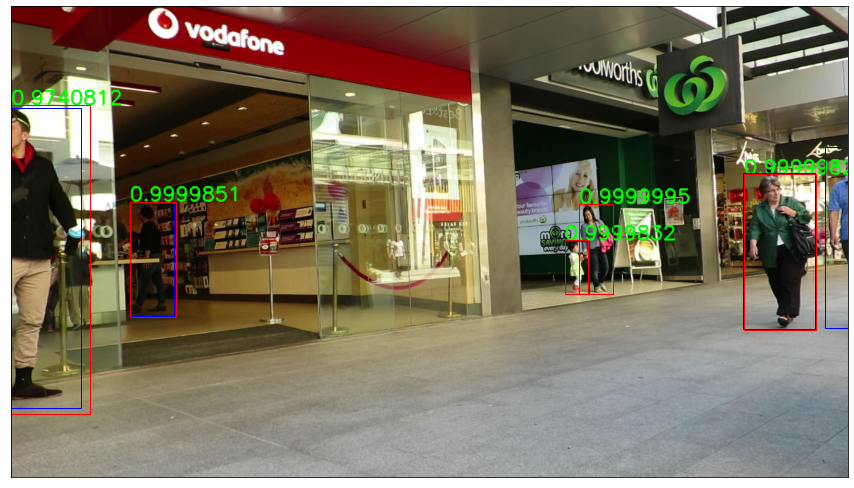

In [ ]:
# TODO 3.1 Run object detection on the same image and compare results to given detection GT
img=frame['img']
img = img.cuda() # Only if GPU, otherwise comment this line
output = obj_detect([img])
img  = img.permute(1, 2,0).cpu().detach().numpy()
print(output)
f = plt.figure(figsize=(15,20)) # display the output image
ax = f.add_subplot(111)

for i in range(len(gt)):
  cur_gt = gt[dict_gt_key[i]]
  x = cur_gt[0]
  y = cur_gt[1]
  w = cur_gt[2]-x
  h = cur_gt[3]-y
  color = list(np.random.choice(range(256), size=3))
  ax.add_patch(mpatches.Rectangle((x,y),w,h,linewidth=1,edgecolor='b',facecolor='none'))

for i in range(len(output[0]['boxes'])):
  cur_model_pred = output[0]['boxes'][i]
  pred_score = str(output[0]['scores'][i].cpu().detach().numpy())
  x = cur_model_pred[0].cpu().detach().numpy()
  y = cur_model_pred[1].cpu().detach().numpy()
  w = cur_model_pred[2].cpu().detach().numpy()-x
  h = cur_model_pred[3].cpu().detach().numpy()-y
  color = list(np.random.choice(range(256), size=3))
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # Convert to RGB
  cv2.putText(img, pred_score, (x,y),  cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,255,0),thickness=3) 
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
  ax.add_patch(mpatches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none'))

plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()


In the next section, run the following evaluation of the object detection training set, you should obtain the following evaluation result:


3.2 TODO: Copy your results to report

AP:  Prec:  Rec:  TP:  FP: 

3.3 what can we learn from the performance?

3.4 Describe pros & cons of the algorithm (at least one for each),based on attched the paper


In [ ]:
data_dir = os.path.join(root_dir, 'data/MOT16/train')
dataset_test = MOT16ObjDetect(data_dir,
                              obj_detect_transforms(train=False))
def collate_fn(batch):
    return tuple(zip(*batch))
data_loader_test = DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

evaluate_obj_detect(obj_detect, data_loader_test)
#3.2 TODO: Copy your results to report

#AP: Prec: Rec: TP: FP:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



AP: 0.8695919777389066 Prec: 0.9153178953298671 Rec: 0.91490984173911 TP: 77986.0 FP: 7215.0


In [ ]:
**YOLO5 Detector results**

4.1 TODO: Implement object detection based on YOLOV5 in PyTorch (pretrained model). 

4.2 Run the algorithm on your image. 

what can we learn from the results? , Which detector architecture has better performance?

4.3 Describe pros & cons of the algorithm (at least one for each). Use the attached paper

In [ ]:
!pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt  # install dependencies


     |████████████████████████████████| 645kB 33.1MB/s 


In [ ]:
import torch
# 4.1 TODO: Implement object detection based on YOLOV5 in PyTorch (pretrained model).
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master


requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...


YOLOv5 🚀 2021-7-8 torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 



requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



Model Summary: 224 layers, 7266973 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
# 4.2 Run the algorithm on your image.
seq = sequences[0]
frame = seq[7] # selcect image according to the final number in your ID X10
img=frame['img']
gt=frame['gt']

img = '/content/gdrive/MyDrive/Colab Notebooks/perception/data/MOT16/train/MOT16-09/img1/000007.jpg'  # or file, PIL, OpenCV, numpy, multiple
results = model(img)  # custom inference size

results.pandas().xyxy # save


[           xmin     ymin       xmax     ymax  confidence  class          name
 0      0.046875  232.875   151.3125  900.000    0.848145      0        person
 1    276.750000  452.625   359.2500  709.875    0.805664      0        person
 2   1690.500000  385.500  1837.5000  737.250    0.795898      0        person
 3   1872.000000  375.750  1920.0000  584.250    0.768555      0        person
 4    113.812500  522.750   195.9375  746.250    0.725098      0        person
 5   1305.000000  458.250  1380.0000  655.500    0.699707      0        person
 6   1418.250000  525.750  1494.7500  642.000    0.610840     56         chair
 7   1782.000000  479.250  1869.0000  580.500    0.546875     26       handbag
 8    866.250000  514.500   908.2500  617.250    0.434570      0        person
 9   1276.500000  541.125  1312.5000  657.375    0.291992      0        person
 10  1216.500000  501.000  1293.0000  565.500    0.265381     58  potted plant]



# Multi-object tracking

A. In this section you will run detection and MOT on 
your traning folder

1. Object Detection with Faster R-CNN and save json file

2. load the json file and run Multiple Object(ID) Tracking with Simple Online and Realtime Tracking(SORT) algorithm

In [9]:
import sys
data_dir = os.path.join(root_dir, 'data/MOT16')
motdata = os.path.join(data_dir,'train/MOT16-09/img1/')
sys.path.append(motdata)
print(motdata)

gdrive/My Drive/Colab Notebooks/perception/data/MOT16/train/MOT16-09/img1/


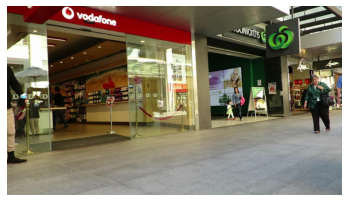

In [ ]:

import matplotlib.pylab as plt
import cv2

list_motdata = os.listdir(motdata)  
list_motdata.sort()

img_ex_path = motdata + list_motdata[0]
img_ex_origin = cv2.imread(img_ex_path)
img_ex = cv2.cvtColor(img_ex_origin, cv2.COLOR_BGR2RGB)

plt.imshow(img_ex)
plt.axis('off')
plt.show()

In [10]:
# Import required packages/modules first

from PIL import Image
import numpy as np
import torch
import torchvision
from torchvision import transforms as T

In [11]:
# Download the pretrained Faster R-CNN model from torchvision

##TODO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [12]:
# Define the class names given by PyTorch's official Docs

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


In [13]:
# Defining a function for get a prediction result from the model

def get_prediction(img_path, threshold):
  img = Image.open(img_path) # Load the image
  transform = T.Compose([T.ToTensor()]) # Defing PyTorch Transform
  img = transform(img) # Apply the transform to the image
  pred = model([img]) # Pass the image to the model
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Score
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return pred_boxes, pred_class,pred_score

In [ ]:
Image is obtained from the image path
The image is converted to image tensor using PyTorch’s Transforms
The image is passed through the model to get the predictions
Class, box coordinates are obtained, but only prediction score > threshold are chosen

In [14]:
# Defining a api function for object detection

def object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=1.5, text_th=3):
 
  boxes, pred_cls,_ = get_prediction(img_path, threshold) # Get predictions
  img = cv2.imread(img_path) # Read image with cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
    cv2.putText(img,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class
  plt.figure(figsize=(15,20)) # display the output image
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

prediction is obtained from get_prediction method
for each prediction, bounding box is drawn and text is written
with opencv
the final image is displayed

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


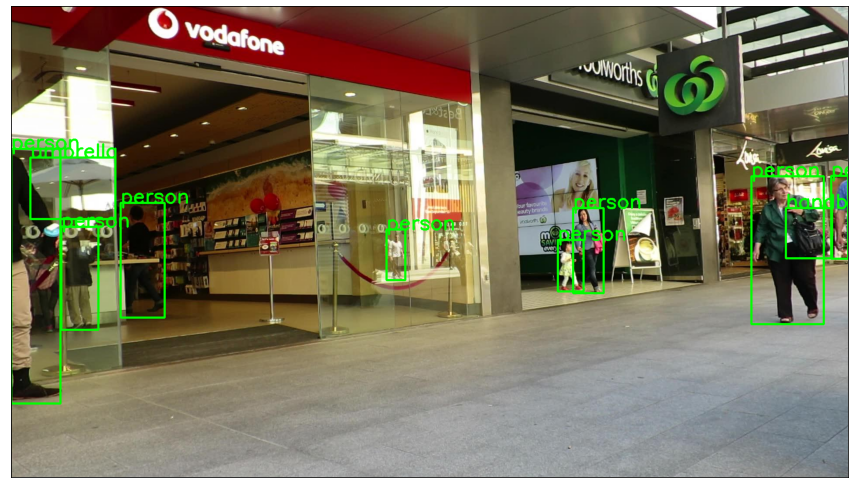

In [ ]:
# Example: After detection
object_detection_api(img_ex_path,threshold=0.8)

The picture above is an example of applying Detection Network (in our case, Faster R-CNN).
Since the purpose of dataset we are using is 'tracking', you can see that most of the detected classes are 'person'.
We need a prediction result (bbs offset, class label, pred scores) for at least 100 images

In [ ]:
# save json file 
import glob
import json

json_dict = {}

path_to_data = os.path.join(data_dir,'train/MOT16-09/img1/*jpg') # fill the correct path

for file_ in sorted(glob.glob(path_to_data)):
  print('start processing ' + file_.split('/')[-1])
  boxes, pred_cls, score = get_prediction(file_, threshold=0.8)
  frames_list = []
  for i in range(len(boxes)):
    frames_list.append({'bbox' : [np.float64(boxes[i][0][0]), np.float64(boxes[i][0][1]), np.float64(boxes[i][1][0]) ,np.float64(boxes[i][1][1])],
                        'labels' : COCO_INSTANCE_CATEGORY_NAMES.index(pred_cls[i]) ,
                        'scores' : np.float64(score[i]) 
                        })
  json_dict[file_.split('/')[-1]]  =  frames_list

with open('data.json', 'w') as outfile:
    json.dump(json_dict, outfile,sort_keys=True)



**Object ID Tracking with SORT**

Simple Online and Realtime Tracking (SORT) algorithm for object ID tracking

In [15]:
# Git clone: SORT Algorithm

!cd "{data_dir}";git clone https://github.com/abewley/sort.git
  
sort = os.path.join(data_dir,'sort/')
sys.path.append(sort)

In [16]:
# requirement for sort
!cd "{sort}";pip install -r requirements.txt

     |████████████████████████████████| 184kB 22.7MB/s 
     |████████████████████████████████| 12.5MB 37.7MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-cp37-none-any.whl size=110476 sha256=1c63d9d6cb6547b0e7e4f0a0c501c892f218d9c9e54d29886c63fad52d992d59
  Stored in directory: /root/.cache/pip/wheels/c3/0c/dd/e92392c3f38a41371602d99fc77d6c1d42aadbf0c6afccdd02
Successfully built filterpy
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scikit-image 0.16.2
    Uninstalling scikit-image-0.16.2:
      Successfully uninstalled scikit-image-0.16.2


In [ ]:
# Optional: if error occurs, you might need to re-install scikit-image and imgaug

!pip uninstall scikit-image
!pip uninstall imgaug
!pip install imgaug
!pip install -U scikit-image

import skimage
print(skimage.__version__)

In [ ]:
# load json file
import json
import collections
from pprint import pprint
from sort import *

jsonpath='data.json' # load the saved json file
with open(jsonpath) as data_file:    
   data = json.load(data_file)
odata = collections.OrderedDict(sorted(data.items()))

In [ ]:
# Let's check out downloaded json file
pprint(odata.keys())
# pprint(odata)


odict_keys(['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg', '000006.jpg', '000007.jpg', '000008.jpg', '000009.jpg', '000010.jpg', '000011.jpg', '000012.jpg', '000013.jpg', '000014.jpg', '000015.jpg', '000016.jpg', '000017.jpg', '000018.jpg', '000019.jpg', '000020.jpg', '000021.jpg', '000022.jpg', '000023.jpg', '000024.jpg', '000025.jpg', '000026.jpg', '000027.jpg', '000028.jpg', '000029.jpg', '000030.jpg', '000031.jpg', '000032.jpg', '000033.jpg', '000034.jpg', '000035.jpg', '000036.jpg', '000037.jpg', '000038.jpg', '000039.jpg', '000040.jpg', '000041.jpg', '000042.jpg', '000043.jpg', '000044.jpg', '000045.jpg', '000046.jpg', '000047.jpg', '000048.jpg', '000049.jpg', '000050.jpg', '000051.jpg', '000052.jpg', '000053.jpg', '000054.jpg', '000055.jpg', '000056.jpg', '000057.jpg', '000058.jpg', '000059.jpg', '000060.jpg', '000061.jpg', '000062.jpg', '000063.jpg', '000064.jpg', '000065.jpg', '000066.jpg', '000067.jpg', '000068.jpg', '000069.jpg', '000070.jpg', '000071.

In [ ]:
img_path = os.path.join(data_dir,'train/MOT16-09/img1/')    # img root path

# Making new directory for saving results
save_path = os.path.join(data_dir,'save/')
!mkdir "{save_path}"

In [ ]:
mot_tracker = Sort()      # Tracker using SORT Algorithm

In [ ]:
for key in odata.keys():   
    arrlist = []
    det_img = cv2.imread(os.path.join(img_path, key))
    overlay = det_img.copy()
    det_result = data[key] 
    
    for info in det_result:
        bbox = info['bbox']
        labels = info['labels']
        scores = info['scores']
        templist = bbox+[scores]
        
        if labels == 1: # label 1 is a person in MS COCO Dataset
            arrlist.append(templist)
            
    track_bbs_ids = mot_tracker.update(np.array(arrlist))
    
    mot_imgid = key.replace('.jpg','')
    newname = save_path + mot_imgid + '_SORT.jpg'
    print(mot_imgid)
    
    for j in range(track_bbs_ids.shape[0]):  
        ele = track_bbs_ids[j, :]
        x = int(ele[0])
        y = int(ele[1])
        x2 = int(ele[2])
        y2 = int(ele[3])
        track_label = str(int(ele[4])) 
        cv2.rectangle(det_img, (x, y), (x2, y2), (0, 255, 255), 4)
        cv2.putText(det_img, '#'+track_label, (x+5, y-10), 0,0.6,(0,255,255),thickness=2)
        
    cv2.imwrite(newname,det_img)

It's all done!

Finally, you can get a sequence of image with each Tracking ID for every detected person.

Prepare 'MOT_SORT.gif' for demo experience (at least 100 frames).

B. Baseline tracker and MOT analysis

In this section we provide you with a simple baseline tracker which predicts object detections for each frame and generates tracks by assigning current detections to previous detections

## Configuration

In [50]:
seed = 12345
seq_name = 'MOT16-09' # TODO fill the correct index
data_dir = os.path.join(root_dir, 'data/MOT16')
output_dir = os.path.join(root_dir, 'output')

## Setup

In [77]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

# dataset
sequences = MOT16Sequences(seq_name, data_dir)

# tracker
class TrackerIoUAssignment(Tracker):

    def data_association(self, boxes, scores):
        if self.tracks:
            track_ids = [t.id for t in self.tracks]
            track_boxes = np.stack([t.box.numpy() for t in self.tracks], axis=0)
            
            distance = mm.distances.iou_matrix(track_boxes, boxes.numpy(), max_iou=0.5) 

            # update existing tracks
            remove_track_ids = []
            for t, dist in zip(self.tracks, distance):
                if np.isnan(dist).all():
                    remove_track_ids.append(t.id)
                else:
                    match_id = np.nanargmin(dist)
                    t.box = boxes[match_id]
            self.tracks = [t for t in self.tracks
                           if t.id not in remove_track_ids]

            # add new tracks
            new_boxes = []
            new_scores = []
            for i, dist in enumerate(np.transpose(distance)):
                if np.isnan(dist).all():
                    new_boxes.append(boxes[i])
                    new_scores.append(scores[i])
            self.add(new_boxes, new_scores)

        else:
            self.add(boxes, scores)
        

tracker = TrackerIoUAssignment(obj_detect)

## Run baseline tracker

In [78]:
time_total = 0
mot_accums = []
results_seq = {}
for seq in sequences:
    tracker.reset()
    now = time.time()

    print(f"Tracking: {seq}")

    data_loader = DataLoader(seq, batch_size=1, shuffle=False)

    for frame in tqdm(data_loader):
        tracker.step(frame)
    results = tracker.get_results()
    results_seq[str(seq)] = results

    if seq.no_gt:
        print(f"No GT evaluation data available.")
    else:
        mot_accums.append(get_mot_accum(results, seq))

    time_total += time.time() - now

    print(f"Tracks found: {len(results)}")
    print(f"Runtime for {seq}: {time.time() - now:.1f} s.")

    seq.write_results(results, os.path.join(output_dir))

print(f"Runtime for all sequences: {time_total:.1f} s.")


Tracking: MOT16-09



Tracks found: 38
Runtime for MOT16-09: 131.8 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/perception/output/MOT16-09.txt
Runtime for all sequences: 131.8 s.


** Multi object tracker analysis **

5.1  Go over the given baseline tracker, what is the main metric for the association bewteen the new detections and existing tracks?

5.2   Open the saved txt file and explain the initial frames results according to [MOT challange paper](https://arxiv.org/pdf/1603.00831.pdf)  

5.3 Analize the  tracking results based on  [**Evaluation Measures**](https://motchallenge.net/results/3D_MOT_2015/?chl=3&orderBy=IDF1&orderStyle=DESC&det=Public) metrics.  

5.4  Change the given baseline tracker metric to Dice score, compare the tracking results to 5.3 .Which metric has better performance?

5.5  Compare the tracking results (baseline tracker) to the given Tractor++ performance. Why do you think [**Tracktor++**](https://arxiv.org/abs/1903.05625) achieves better results? what are the main differences between the trackers (based on the paper)?

5.6  Describe pros & cons of SORT and Tracktor++ trackers (at least pros & cons one for each). Use the attached papaer

In [54]:
evaluate_mot_accums(mot_accums,
                     [str(s) for s in sequences if not s.no_gt],
                     generate_overall=True)

         IDF1   IDP  IDR  Rcll  Prcn GT MT PT ML   FP   FN IDs   FM   MOTA  MOTP
MOT16-09 8.6% 15.3% 6.0% 10.7% 27.2% 26  0  5 21 1529 4754   2  109 -18.0% 0.070
OVERALL  8.6% 15.3% 6.0% 10.7% 27.2% 26  0  5 21 1529 4754   2  109 -18.0% 0.070


The current state-of-the-art multi-object tracker [Tracktor++](https://arxiv.org/abs/1903.05625) achieves the following tracking results on the `MOT16-train` sequences:

              IDF1   IDP   IDR  Rcll  Prcn  GT  MT  PT  ML  FP    FN IDs   FM  MOTA  MOTP
    MOT16-02 45.8% 78.3% 32.4% 41.3% 99.8%  62   9  32  21  18 10909  59   68 40.9% 0.080
    MOT16-04 71.1% 90.3% 58.6% 64.7% 99.8%  83  32  29  22  71 16785  22   29 64.5% 0.096
    MOT16-05 64.0% 86.6% 50.7% 57.5% 98.1% 133  32  65  36  75  2942  37   59 55.8% 0.144
    MOT16-09 54.6% 69.4% 45.0% 64.3% 99.1%  26  11  13   2  31  1903  22   31 63.3% 0.086
    MOT16-10 64.3% 75.7% 55.9% 72.4% 98.0%  57  28  26   3 189  3543  71  125 70.4% 0.148
    MOT16-11 63.3% 77.0% 53.7% 69.0% 98.9%  75  24  33  18  73  2924  26   26 68.0% 0.081
    MOT16-13 73.6% 85.1% 64.8% 74.2% 97.6% 110  60  39  11 213  3000  62   90 71.9% 0.132
    OVERALL  65.0% 84.0% 53.1% 62.6% 99.1% 546 196 237 113 670 42006 299  428 61.7% 0.106

For your final submission you should focus on improving `MOTA`.

## Visualize tracking results

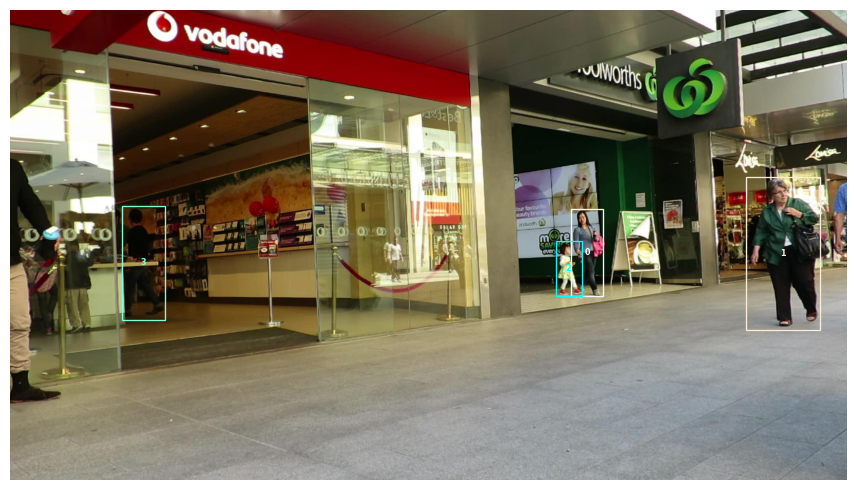

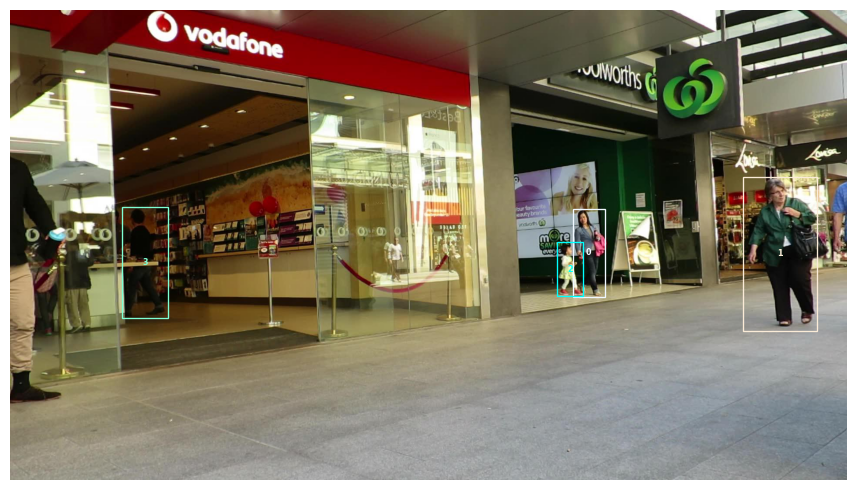

In [ ]:
plot_sequence(results_seq['MOT16-09'],
              [s for s in sequences if str(s) == 'MOT16-09'][0],
              first_n_frames=2)

# Notes 

*   Experiment and debug on a single train sequence. If something works on a single sequence evaluate all train sequences to check the generaliztion of your improvement.
*   Remember to split the training set into multiple sets with different sequences if you train something and want to avoid overfitting.
*   Sometimes the execution of a cell gets stuck. If this happends just abort the execution and restart the cell.
*   If the notebook warns you that currently no GPU hardware acceleration is available, try again later and focus on some debugging or experiments than can be done only with the CPU.
